# Threshold Optimization

### Imports and data loading

In [22]:
# Numerical operations (arrays, vectorized computations)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Metrics needed for threshold analysis
from sklearn.metrics import (
    precision_recall_curve,       # compute precision/recall across thresholds
    confusion_matrix,             # summarize FP/FN/TP/TN at a chosen threshold
    roc_auc_score,
    average_precision_score        
)


# Load dataset
df = pd.read_csv("../data/transactions.csv")

### Feature selection and target

In [23]:
# Define the same feature set used previously (ensures fair reproducibility)
features = [
    "amount", 
    "night", 
    "weekend", 
    "country_change", 
    "velocity", 
    "device_risk"
    ]

# Build feature matrix (X) and target vector (y)
X = df[features]
y = df["is_fraud"]



### Train–test split

In [24]:
# Stratified split keeps the fraud rate similar in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42,
)

### Recalculate Logistic Regression

In [25]:
# Scale features for logistic regression (important for stable optimization)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)        

# Train logistic regression baseline (with class balancing for rare fraud cases)
log_model = LogisticRegression(
    max_iter=1000,             # allow enough iterations to converge
    class_weight="balanced",   # counter class imbalance
    random_state=42,
)

# Fit the model on the scaled training data
log_model.fit(X_train_scaled, y_train)

# Predict probabilities for the positive class (fraud = 1)
y_prob = log_model.predict_proba(X_test_scaled)[:, 1]

# Quick sanity check metrics (optional but useful)
logistic_roc = roc_auc_score(y_test, y_prob)
logistic_pr = average_precision_score(y_test, y_prob)

print(f"Baseline Logistic ROC-AUC: {logistic_roc:.3f}")
print(f"Baseline Logistic PR-AUC:  {logistic_pr:.3f}")

Baseline Logistic ROC-AUC: 0.748
Baseline Logistic PR-AUC:  0.051


### Precision–Recall curve (threshold behavior)

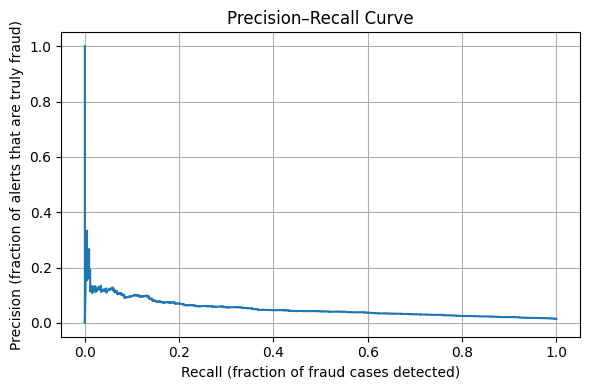

In [26]:
# Compute precision and recall for all possible probability thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Plot the Precision–Recall curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision)

# Label axes clearly (business interpretation depends on these)
plt.xlabel("Recall (fraction of fraud cases detected)")
plt.ylabel("Precision (fraction of alerts that are truly fraud)")

# Title describes what the plot represents
plt.title("Precision–Recall Curve")

# Grid makes it easier to read approximate values
plt.grid(True)

# Ensure labels fit nicely in the figure
plt.tight_layout()

# Render the plot
plt.show()


### Choose an operational threshold (minimum precision constraint)

In [27]:
# Define a minimum acceptable precision level (example: 10%)
# Interpretation: at least 1 true fraud for every 10 alerts
target_precision = 0.10

# Find indices where precision meets or exceeds the target
valid_idx = np.where(precision[:-1] >= target_precision)[0]
# precision[:-1] ensures we align with thresholds length

# If there are no thresholds meeting the target, handle gracefully
if len(valid_idx) == 0:
    raise ValueError(
        "No threshold achieves the requested minimum precision. "
        "Try lowering target_precision (e.g., 0.05) or improving the model/features."
    )

# Select the last valid index to maximize recall while keeping precision >= target
selected_idx = valid_idx[-1]

# Now this is guaranteed to be valid
selected_threshold = thresholds[selected_idx]

print(f"Selected threshold (precision ≥ {target_precision:.0%}): {selected_threshold:.4f}")
print(f"Precision at threshold: {precision[selected_idx]:.3f}")
print(f"Recall at threshold:    {recall[selected_idx]:.3f}")



Selected threshold (precision ≥ 10%): 0.9816
Precision at threshold: 0.200
Recall at threshold:    0.002


### Apply the threshold and inspect the confusion matrix

In [28]:
# Convert probabilities into binary predictions using the selected threshold
# If probability >= threshold -> predict fraud (1), else non-fraud (0)
y_pred_custom = (y_prob >= selected_threshold).astype(int)

# Compute confusion matrix: [[TN, FP], [FN, TP]]
cm = confusion_matrix(y_test, y_pred_custom)

# Unpack values for readability
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix at selected threshold")
print("------------------------------------")
print(f"True Negatives  (TN): {tn}  -> legitimate transactions correctly accepted")
print(f"False Positives (FP): {fp}  -> legitimate transactions incorrectly flagged (false alerts)")
print(f"False Negatives (FN): {fn}  -> fraud transactions missed (escaped fraud)")
print(f"True Positives  (TP): {tp}  -> fraud transactions correctly detected")
print()
print(f"Threshold used: {selected_threshold:.4f}")


Confusion Matrix at selected threshold
------------------------------------
True Negatives  (TN): 29554  -> legitimate transactions correctly accepted
False Positives (FP): 4  -> legitimate transactions incorrectly flagged (false alerts)
False Negatives (FN): 441  -> fraud transactions missed (escaped fraud)
True Positives  (TP): 1  -> fraud transactions correctly detected

Threshold used: 0.9816


### Precision and recall at the selected threshold

In [29]:
# Compute precision and recall at the chosen threshold
# Precision = TP / (TP + FP)
# Recall    = TP / (TP + FN)
precision_custom = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall_custom = tp / (tp + fn) if (tp + fn) > 0 else 0.0

print("Operational metrics at selected threshold")
print("----------------------------------------")
print(f"Precision: {precision_custom:.2%}")
print(f"Recall:    {recall_custom:.2%}")


Operational metrics at selected threshold
----------------------------------------
Precision: 20.00%
Recall:    0.23%


### Cost-based threshold (optional, but very realistic)

In [30]:
# Define business costs (example values)
# FP = cost of reviewing a legitimate alert (analyst time + customer friction)
# FN = cost of missing fraud (direct loss + potential downstream impact)
cost_fp = 1.0
cost_fn = 10.0

# Evaluate cost across thresholds
# Note: thresholds returned by PR curve are possible cutoffs for y_prob
costs = []

for t in thresholds:
    preds = (y_prob >= t).astype(int)
    tn_t, fp_t, fn_t, tp_t = confusion_matrix(y_test, preds).ravel()
    
    # Total cost = FP * cost_fp + FN * cost_fn
    total_cost = fp_t * cost_fp + fn_t * cost_fn
    costs.append(total_cost)

costs = np.array(costs)

# Choose threshold that minimizes total cost
best_idx = np.argmin(costs)
best_threshold_cost = thresholds[best_idx]

print(f"Best cost-based threshold: {best_threshold_cost:.4f}")
print(f"Minimum total cost: {costs[best_idx]:.1f}")


Best cost-based threshold: 0.9061
Minimum total cost: 4337.0


### Apply the selected threshold and generate predictions

In [31]:
# Convert predicted probabilities into binary predictions using the selected threshold
# If probability >= threshold -> predict fraud (1), else predict non-fraud (0)
y_pred_custom = (y_prob >= selected_threshold).astype(int)

# Quick sanity check: count how many transactions are flagged as fraud
n_alerts = y_pred_custom.sum()
print(f"Number of alerts (predicted fraud = 1): {n_alerts:,}")


Number of alerts (predicted fraud = 1): 5


### Confusion matrix at the selected threshold

In [32]:
# Compute the confusion matrix for the chosen threshold
# Output format: [[TN, FP],
#                 [FN, TP]]
cm = confusion_matrix(y_test, y_pred_custom)

# Unpack confusion matrix values for readability
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix (selected threshold)")
print("-------------------------------------")
print(f"TN (legit correctly accepted): {tn:,}")
print(f"FP (legit incorrectly flagged): {fp:,}")
print(f"FN (fraud missed):             {fn:,}")
print(f"TP (fraud correctly detected): {tp:,}")


Confusion Matrix (selected threshold)
-------------------------------------
TN (legit correctly accepted): 29,554
FP (legit incorrectly flagged): 4
FN (fraud missed):             441
TP (fraud correctly detected): 1


### Precision, recall and alert quality at the selected threshold

In [33]:
# Compute precision and recall explicitly for transparency
# Precision = TP / (TP + FP) -> quality of alerts
# Recall    = TP / (TP + FN) -> fraction of fraud captured
precision_custom = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall_custom = tp / (tp + fn) if (tp + fn) > 0 else 0.0

# Alert rate = fraction of all transactions flagged as fraud
alert_rate = (tp + fp) / len(y_test)

print("Operational metrics (selected threshold)")
print("---------------------------------------")
print(f"Threshold:  {selected_threshold:.4f}")
print(f"Precision:  {precision_custom:.2%}")
print(f"Recall:     {recall_custom:.2%}")
print(f"Alert rate: {alert_rate:.2%}  (share of transactions flagged)")


Operational metrics (selected threshold)
---------------------------------------
Threshold:  0.9816
Precision:  20.00%
Recall:     0.23%
Alert rate: 0.02%  (share of transactions flagged)


### Visualize precision and recall as a function of the threshold

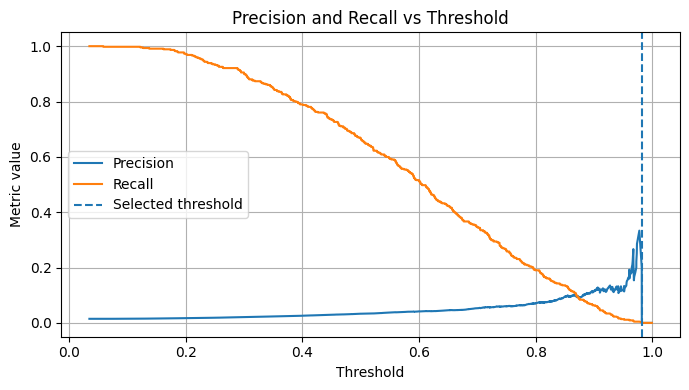

In [34]:
# Plot precision and recall vs threshold to visualize the trade-off
# Note: precision and recall have length = len(thresholds) + 1
# We align them by using precision[:-1] and recall[:-1]
plt.figure(figsize=(7, 4))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")

# Mark the selected threshold
plt.axvline(selected_threshold, linestyle="--", label="Selected threshold")

plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.title("Precision and Recall vs Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Cost-based threshold selection (FP vs FN costs)

In [35]:
# Define business costs (example values)
# FP cost: investigating a false alert (analyst time, customer friction)
# FN cost: missing a fraud (direct financial loss + downstream impact)
cost_fp = 1.0
cost_fn = 10.0

# Evaluate total cost for each possible threshold
costs = []

for t in thresholds:
    # Generate predictions for this threshold
    preds = (y_prob >= t).astype(int)
    
    # Compute confusion matrix and unpack values
    tn_t, fp_t, fn_t, tp_t = confusion_matrix(y_test, preds).ravel()
    
    # Total cost = FP * cost_fp + FN * cost_fn
    total_cost = fp_t * cost_fp + fn_t * cost_fn
    costs.append(total_cost)

# Convert to numpy array for easier processing
costs = np.array(costs)

# Choose the threshold that minimizes total cost
best_idx = np.argmin(costs)
best_threshold_cost = thresholds[best_idx]

print(f"Cost-based best threshold: {best_threshold_cost:.4f}")
print(f"Minimum total cost: {costs[best_idx]:.1f}")
print(f"Assumed costs -> FP: {cost_fp}, FN: {cost_fn}")


Cost-based best threshold: 0.9061
Minimum total cost: 4337.0
Assumed costs -> FP: 1.0, FN: 10.0


### Compare minimum-precision threshold vs cost-based threshold

In [36]:
def evaluate_threshold(y_true, y_prob, threshold):
    """
    Evaluate a threshold by returning confusion matrix counts and key operational metrics.
    """
    preds = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    alert_rate = (tp + fp) / len(y_true)
    return tn, fp, fn, tp, prec, rec, alert_rate

# Evaluate both thresholds
tn1, fp1, fn1, tp1, p1, r1, ar1 = evaluate_threshold(y_test, y_prob, selected_threshold)
tn2, fp2, fn2, tp2, p2, r2, ar2 = evaluate_threshold(y_test, y_prob, best_threshold_cost)

# Summarize in a small table
comparison = pd.DataFrame({
    "Threshold type": ["Min precision", "Cost-based"],
    "Threshold": [selected_threshold, best_threshold_cost],
    "Precision": [p1, p2],
    "Recall": [r1, r2],
    "Alert rate": [ar1, ar2],
    "FP": [fp1, fp2],
    "FN": [fn1, fn2],
    "TP": [tp1, tp2],
})

comparison


,Threshold type,Threshold,Precision,Recall,Alert rate,FP,FN,TP
0,Min precision,0.981613,0.200000,0.002262,0.000167,4,441,1
1,Cost-based,0.906094,0.128079,0.058824,0.006767,177,416,26


## Summary Threshold Optimization (Operational Decision-Making)

In this part, I moved beyond evaluating the model with standard metrics (ROC-AUC and PR-AUC) and focused on how the model would be used in a real production setting. Instead of relying on the default classification threshold (0.5), I analyzed how different probability thresholds impact business outcomes such as alert volume, fraud detection rate, and operational cost.

---

### Precision–Recall trade-off

Using the Precision–Recall curve, I explored the trade-off between:

- **Precision**: how many alerts are truly fraudulent (alert quality)
- **Recall**: how many fraud cases are actually detected (fraud coverage)

This analysis shows that increasing the threshold improves precision but drastically reduces recall, while lowering the threshold increases recall at the cost of more false positives. Therefore, choosing a threshold is a business decision, not only a technical one.

---

### Strategy 1: Minimum precision constraint (quality-first approach)

I selected the highest threshold that guarantees a minimum precision of 20% (at least 1 real fraud per 10 alerts).

**Results:**
- Threshold: 0.9816  
- Precision: 20.0%  
- Recall: 0.23%  
- Alert rate: 0.02%  
- TP: 1  
- FP: 4  
- FN: 441  

**Interpretation:**

This threshold is extremely conservative. It produces very few alerts and almost no false positives, but it misses nearly all fraud cases. This setup would only be acceptable in scenarios where operational capacity is extremely limited and false alarms are very costly, but it provides very poor fraud coverage.

---

### Strategy 2: Cost-based threshold (business-optimized approach)

I defined explicit business costs:

- False Positive (FP) cost = 1  
- False Negative (FN) cost = 10  

This reflects the idea that missing a fraud is much more expensive than reviewing a false alert.

I then selected the threshold that minimizes the total business cost.

**Results:**
- Threshold: 0.9061  
- Precision: 12.8%  
- Recall: 5.88%  
- Alert rate: 0.67%  
- TP: 26  
- FP: 177  
- FN: 416  

**Interpretation:**

The cost-based threshold captures significantly more fraud cases while keeping the alert volume relatively low. Although it generates more false positives than the minimum-precision strategy, it minimizes the overall business cost and represents a much more realistic operational trade-off.

---

### Comparison of both strategies

| Strategy        | Threshold | Precision | Recall | Alert rate | TP | FP  | FN  |
|-----------------|-----------|-----------|--------|------------|----|-----|-----|
| Min precision   | 0.9816    | 20.0%     | 0.23%  | 0.02%      | 1  | 4   | 441 |
| Cost-based      | 0.9061    | 12.8%     | 5.88%  | 0.67%      | 26 | 177 | 416 |

---

### Key takeaway

The threshold optimization step revealed a strong trade-off between precision and recall.
When enforcing high precision (to limit false alerts and operational burden), the resulting recall was very low, meaning that most fraudulent transactions remained undetected.

This phase highlights that model deployment decisions should be driven by business constraints, not only by offline performance metrics. Threshold selection is a critical operational decision that directly impacts fraud losses, customer friction, and operational workload. Optimizing the threshold based on business costs leads to more realistic and actionable model behavior in production.

